## Set up

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import requests
import zipfile
import io
import numbers

from datetime import datetime, timedelta
from tqdm import tqdm

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [42]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Collection

In [43]:
START_DATE = '2009-12-01'
END_DATE = '2011-12-31'

### Holidays

In [44]:
# Dataset proposed by this paper: https://shorturl.at/P8Mcs
HOLIDAYS_URL = 'https://data.worldpop.org/GIS/Holiday_Data/public_holidays/public_holidays_2010_2019.zip'

response = requests.get(HOLIDAYS_URL)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]  # Assuming there's only one CSV file
    with zip_ref.open(csv_filename) as file:
        holidays_df = pd.read_csv(file)

holidays_df['Date'] = pd.to_datetime(holidays_df['Date'], format='%d/%m/%Y')

holidays_df.head()

,ADM_name,ISO3,Date,Name,Type
0,Aruba,ABW,2010-01-01,New Year's Day,Public holiday
1,Aruba,ABW,2010-01-25,Betico Croes' Birthday,Public holiday
2,Aruba,ABW,2010-02-15,Carnival Monday,Public holiday
3,Aruba,ABW,2010-03-18,National Anthem and Flag Day,Public holiday
4,Aruba,ABW,2010-04-02,Good Friday,Public holiday


In [45]:
uk_holidays = holidays_df[lambda x: x['ISO3'] == 'GBR']
uk_holidays

,ADM_name,ISO3,Date,Name,Type
14015,Uk,GBR,2010-01-04,2nd January (substitute day),Local holiday
14016,Uk,GBR,2010-03-17,St Patrick's Day,Local holiday
14017,Uk,GBR,2010-04-05,Easter Monday,Local holiday
14018,Uk,GBR,2010-07-12,Battle of the Boyne,Local holiday
14019,Uk,GBR,2010-08-02,Summer Bank Holiday,Local holiday
...,...,...,...,...,...
14297,Uk,GBR,2019-04-19,Good Friday,Public holiday
14298,Uk,GBR,2019-05-06,Early May Bank Holiday,Public holiday
14299,Uk,GBR,2019-05-27,Spring Bank Holiday,Public holiday
14300,Uk,GBR,2019-12-25,Christmas Day,Public holiday


In [46]:
uk_holidays['Type'].value_counts() 

Type
Observance          134
Local holiday        79
Public holiday       64
Local observance     10
Name: count, dtype: int64

In [47]:
uk_holidays[lambda x: x['Type'] == 'Local holiday']['Name'].unique()

array(['2nd January (substitute day)', "St Patrick's Day",
       'Easter Monday', 'Battle of the Boyne', 'Summer Bank Holiday',
       "St Andrew's Day", "Day off for St Patrick's Day", '2nd January',
       "St Andrew's Day observed", 'Battle of the Boyne observed'],
      dtype=object)

In [48]:
uk_holidays[lambda x: x['Type'] == 'Public holiday']['Name'].unique()

array(['Good Friday', 'Early May Bank Holiday', 'Spring Bank Holiday',
       'Christmas Day', 'Boxing Day',
       'Substitute Bank Holiday for Christmas Day',
       'Substitute Bank Holiday for Boxing Day', "New Year's Day Holiday",
       "New Year's Day observed", 'Royal Wedding Bank Holiday',
       "The Queen's Diamond Jubilee", "New Year's Day"], dtype=object)

In [49]:
uk_holidays_in_data_range = uk_holidays[
    lambda x: (START_DATE <= x['Date']) & (x['Date'] <= END_DATE) & (x['Type'].isin(['Public holiday', 'Local holiday']))
].sort_values(by='Date')
uk_holidays_in_data_range = uk_holidays_in_data_range[['Date', 'Name']].set_index('Date')['Name']
uk_holidays_in_data_range

Date
2010-01-04                 2nd January (substitute day)
2010-03-17                             St Patrick's Day
2010-04-02                                  Good Friday
2010-04-05                                Easter Monday
2010-05-03                       Early May Bank Holiday
2010-05-31                          Spring Bank Holiday
2010-07-12                          Battle of the Boyne
2010-08-02                          Summer Bank Holiday
2010-08-30                          Summer Bank Holiday
2010-11-30                              St Andrew's Day
2010-12-25                                Christmas Day
2010-12-26                                   Boxing Day
2010-12-27    Substitute Bank Holiday for Christmas Day
2010-12-28       Substitute Bank Holiday for Boxing Day
2011-01-03                      New Year's Day observed
2011-01-03                       New Year's Day Holiday
2011-01-04                 2nd January (substitute day)
2011-03-17                             St P

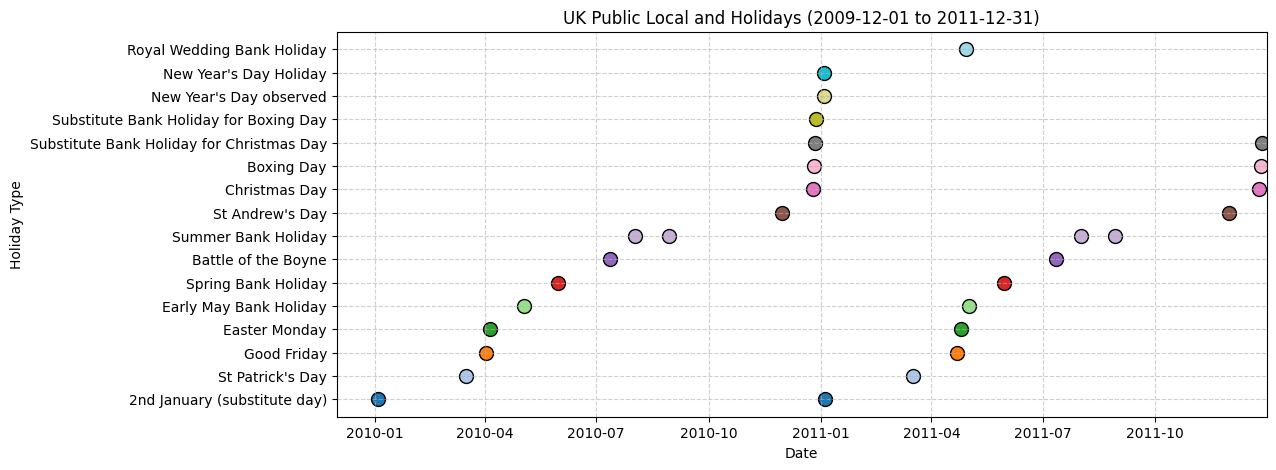

In [50]:
date_range = pd.date_range(start=START_DATE, end=END_DATE)

fig, ax = plt.subplots(figsize=(12, 5))

holiday_types = uk_holidays_in_data_range.unique()
colormap = plt.colormaps["tab20"]
colors = colormap(np.linspace(0, 1, len(holiday_types)))
color_map = dict(zip(holiday_types, colors))

# Plot each holiday type
for holiday, color in color_map.items():
    subset = uk_holidays_in_data_range[uk_holidays_in_data_range == holiday]
    ax.scatter(subset.index, [holiday] * len(subset), color=color, label=holiday, s=100, edgecolors="black")

# Formatting the plot
ax.set_xlim(pd.Timestamp(START_DATE), pd.Timestamp(END_DATE))  # Ensure full range
plt.xlabel("Date")
plt.ylabel("Holiday Type")
plt.title(f"UK Public Local and Holidays ({START_DATE} to {END_DATE})")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

In [51]:
SAVE_DIR = '../../dataset/explanatory_variables'
SAVE_FILENAME = 'public_holidays.json'

os.makedirs(SAVE_DIR, exist_ok=True)

# Convert to dictionary
holidays = uk_holidays_in_data_range.to_dict()

holidays = {
    str(date): holiday_name
    for date, holiday_name in uk_holidays_in_data_range.items()
}

# Save as pretty-printed JSON
with open(os.path.join(SAVE_DIR, SAVE_FILENAME), 'w') as f:
    json.dump(holidays, f, indent=4)

### Consumer Price Index

In [52]:
# Source: https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/el2q/mm23
URL = 'https://www.ons.gov.uk/generator?format=csv&uri=/economy/inflationandpriceindices/timeseries/el2q/mm23'

response = requests.get(URL)

if response.status_code == 200:
    # Convert the content of the response to a StringIO object (to simulate file reading)
    csv_data = io.StringIO(response.text)
    
    # Read the CSV data into a DataFrame
    cpi_df = pd.read_csv(csv_data)
    
    # Display the first few rows of the DataFrame
    print(cpi_df.head())
else:
    print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")

               Title CPIY: Index level (2015=100)
0               CDID                         EL2Q
1  Source dataset ID                         MM23
2            PreUnit                          NaN
3               Unit       Index, base year = 100
4       Release date                   16-04-2025


In [53]:
list(cpi_df.columns.values)

['Title', 'CPIY: Index level (2015=100)']

In [54]:
cpi_df['Title'].unique()

array(['CDID', 'Source dataset ID', 'PreUnit', 'Unit', 'Release date',
       'Next release', 'Important notes', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2003 Q1',
       '2003 Q2', '2003 Q3', '2003 Q4', '2004 Q1', '2004 Q2', '2004 Q3',
       '2004 Q4', '2005 Q1', '2005 Q2', '2005 Q3', '2005 Q4', '2006 Q1',
       '2006 Q2', '2006 Q3', '2006 Q4', '2007 Q1', '2007 Q2', '2007 Q3',
       '2007 Q4', '2008 Q1', '2008 Q2', '2008 Q3', '2008 Q4', '2009 Q1',
       '2009 Q2', '2009 Q3', '2009 Q4', '2010 Q1', '2010 Q2', '2010 Q3',
       '2010 Q4', '2011 Q1', '2011 Q2', '2011 Q3', '2011 Q4', '2012 Q1',
       '2012 Q2', '2012 Q3', '2012 Q4', '2013 Q1', '2013 Q2', '2013 Q3',
       '2013 Q4', '2014 Q1', '2014 Q2', '2014 Q3', '2014 Q4', '2015 Q1',
       '2015 Q2', '2015 Q3', '2015 Q4', '2016 Q1', '2016 Q2', '2016 Q3',
       '2016 Q4', '2017 Q1', '2017 Q2', '2017 Q3', '2

In [55]:
monthly_cpi_df = cpi_df[
    lambda x: (
        x['Title'].str.match(r'^\d{4} [A-Z]{3}$', na=False)
    )
]
monthly_cpi_df['CPIY: Index level (2015=100)'] = pd.to_numeric(
    monthly_cpi_df['CPIY: Index level (2015=100)'], errors='coerce').dropna()
dates = pd.to_datetime(monthly_cpi_df['Title'])
cpi = monthly_cpi_df['CPIY: Index level (2015=100)'].astype(float)

uk_monthly_cpi_df = pd.DataFrame({
    'Date': dates,
    'CPI': cpi,
})

uk_monthly_cpi_df = uk_monthly_cpi_df[
    lambda x: (START_DATE <= x['Date']) & (x['Date'] <= END_DATE)
]

uk_monthly_cpi = uk_monthly_cpi_df.set_index('Date')
uk_monthly_cpi

,CPI
Date,
2009-12-01,90.7
2010-01-01,89.2
2010-02-01,89.6
2010-03-01,90.1
2010-04-01,90.4
2010-05-01,90.6
2010-06-01,90.8
2010-07-01,90.6
2010-08-01,91.1


In [56]:
uk_daily_cpi = uk_monthly_cpi.resample('D').mean()
uk_daily_cpi = uk_daily_cpi.sort_index()
uk_daily_cpi = uk_daily_cpi.ffill()
uk_daily_cpi

,CPI
Date,
2009-12-01,90.7
2009-12-02,90.7
2009-12-03,90.7
2009-12-04,90.7
2009-12-05,90.7
...,...
2011-11-27,94.7
2011-11-28,94.7
2011-11-29,94.7


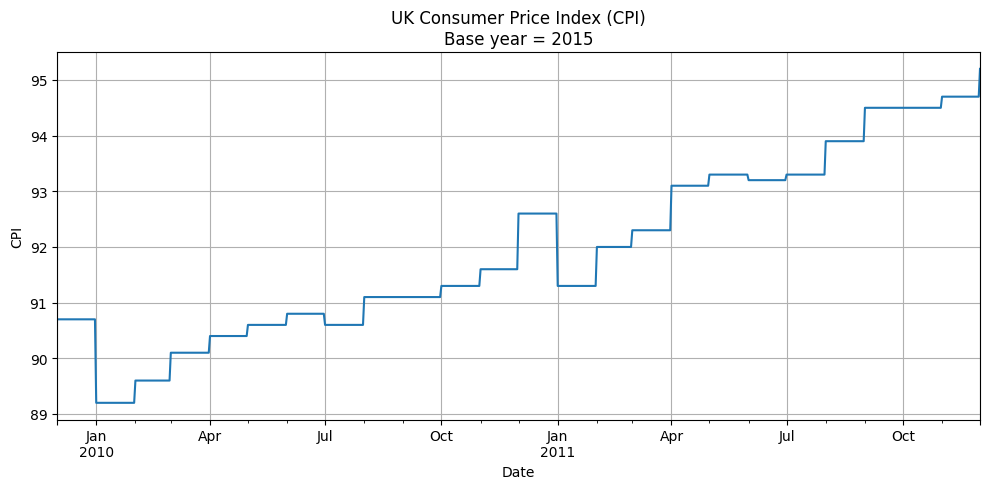

In [57]:
fig, ax = plt.subplots(figsize=(10,5))

uk_daily_cpi.plot(ax=ax)

ax.set_title('UK Consumer Price Index (CPI)\nBase year = 2015')
ax.set_xlabel('Date')
ax.set_ylabel('CPI')
ax.grid(True)
ax.legend().remove()

plt.tight_layout()
plt.show()

In [58]:
SAVE_DIR = '../../dataset/explanatory_variables'
SAVE_FILENAME = 'cpi.json'

os.makedirs(SAVE_DIR, exist_ok=True)

# Convert to dictionary
cpi = uk_daily_cpi.to_dict()['CPI']

cpi = {
    str(date): cpi
    for date, cpi in cpi.items()
}

# Save as pretty-printed JSON
with open(os.path.join(SAVE_DIR, SAVE_FILENAME), 'w') as f:
    json.dump(cpi, f, indent=4)

### Consumer Confidence Index

In [59]:
# Source: https://www.oecd.org/en/data/indicators/consumer-confidence-index-cci.html?utm_source=chatgpt.com&oecdcontrol-b2a0dbca4d-var3=1974-09&oecdcontrol-b2a0dbca4d-var4=2024-01
URL = 'https://sdmx.oecd.org/public/rest/data/OECD.SDD.STES,DSD_STES@DF_CLI,/.M.LI...AA...H?dimensionAtObservation=AllDimensions&format=csvfilewithlabels'

response = requests.get(URL)

if response.status_code == 200:
    # Convert the content of the response to a StringIO object (to simulate file reading)
    csv_data = io.StringIO(response.text)
    
    # Read the CSV data into a DataFrame
    cci_df = pd.read_csv(csv_data)
    
    # Display the first few rows of the DataFrame
    print(cci_df.head())
else:
    print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")

  STRUCTURE                        STRUCTURE_ID                STRUCTURE_NAME  \
0  DATAFLOW  OECD.SDD.STES:DSD_STES@DF_CLI(4.1)  Composite leading indicators   
1  DATAFLOW  OECD.SDD.STES:DSD_STES@DF_CLI(4.1)  Composite leading indicators   
2  DATAFLOW  OECD.SDD.STES:DSD_STES@DF_CLI(4.1)  Composite leading indicators   
3  DATAFLOW  OECD.SDD.STES:DSD_STES@DF_CLI(4.1)  Composite leading indicators   
4  DATAFLOW  OECD.SDD.STES:DSD_STES@DF_CLI(4.1)  Composite leading indicators   

  ACTION REF_AREA Reference area FREQ Frequency of observation MEASURE  \
0      I      AUS      Australia    M                  Monthly      LI   
1      I      AUS      Australia    M                  Monthly      LI   
2      I      AUS      Australia    M                  Monthly      LI   
3      I      AUS      Australia    M                  Monthly      LI   
4      I      AUS      Australia    M                  Monthly      LI   

                             Measure  ... OBS_VALUE Observation valu

In [60]:
cci_df.columns

Index(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'REF_AREA',
       'Reference area', 'FREQ', 'Frequency of observation', 'MEASURE',
       'Measure', 'UNIT_MEASURE', 'Unit of measure', 'ACTIVITY',
       'Economic activity', 'ADJUSTMENT', 'Adjustment', 'TRANSFORMATION',
       'Transformation', 'TIME_HORIZ', 'Time horizon', 'METHODOLOGY',
       'Calculation methodology', 'TIME_PERIOD', 'Time period', 'OBS_VALUE',
       'Observation value', 'OBS_STATUS', 'Observation status', 'UNIT_MULT',
       'Unit multiplier', 'DECIMALS', 'Decimals', 'BASE_PER', 'Base period'],
      dtype='object')

In [61]:
cci_df['REF_AREA'].value_counts()

REF_AREA
USA      843
NAFTA    842
CAN      831
GBR      808
JPN      795
G7       795
DEU      771
G20      771
G4E      760
ITA      760
AUS      710
FRA      701
ZAF      603
MEX      519
ESP      483
TUR      448
BRA      435
KOR      423
CHN      395
A5M      395
IDN      375
IND      372
Name: count, dtype: int64

In [62]:
cci_df['TIME_PERIOD'].value_counts()

TIME_PERIOD
2001-03    22
2005-05    22
2004-09    22
2004-10    22
2004-11    22
           ..
1955-05     2
1955-04     2
1955-03     2
1955-02     2
1955-01     1
Name: count, Length: 843, dtype: int64

In [63]:
cci_df['OBS_VALUE'].value_counts()

OBS_VALUE
100.04740    5
100.01840    4
100.46340    4
100.90980    4
100.15460    4
            ..
98.78821     1
98.86867     1
98.89735     1
98.85214     1
100.42790    1
Name: count, Length: 12796, dtype: int64

In [64]:
uk_monthly_cci_df = cci_df.query('REF_AREA == "GBR"')[['TIME_PERIOD', 'OBS_VALUE']]
uk_monthly_cci_df = uk_monthly_cci_df.rename(columns={
    'TIME_PERIOD': 'Date',
    'OBS_VALUE': 'CCI'
})
uk_monthly_cci_df['Date'] = pd.to_datetime(uk_monthly_cci_df['Date'])
uk_monthly_cci_df = uk_monthly_cci_df.query(f'"{START_DATE}" <= Date and Date <= "{END_DATE}"')
uk_monthly_cci = uk_monthly_cci_df.set_index('Date').sort_index()
uk_monthly_cci

,CCI
Date,
2009-12-01,101.63830
2010-01-01,101.77650
2010-02-01,101.79910
2010-03-01,101.73640
2010-04-01,101.60230
2010-05-01,101.41190
2010-06-01,101.20540
2010-07-01,101.01370
2010-08-01,100.87560


In [65]:
uk_daily_cci = uk_monthly_cci.resample('D').mean()
uk_daily_cci = uk_daily_cci.sort_index()
uk_daily_cci = uk_daily_cci.ffill()
uk_daily_cci = uk_daily_cci.round(2)
uk_daily_cci

,CCI
Date,
2009-12-01,101.64
2009-12-02,101.64
2009-12-03,101.64
2009-12-04,101.64
2009-12-05,101.64
...,...
2011-11-27,98.31
2011-11-28,98.31
2011-11-29,98.31


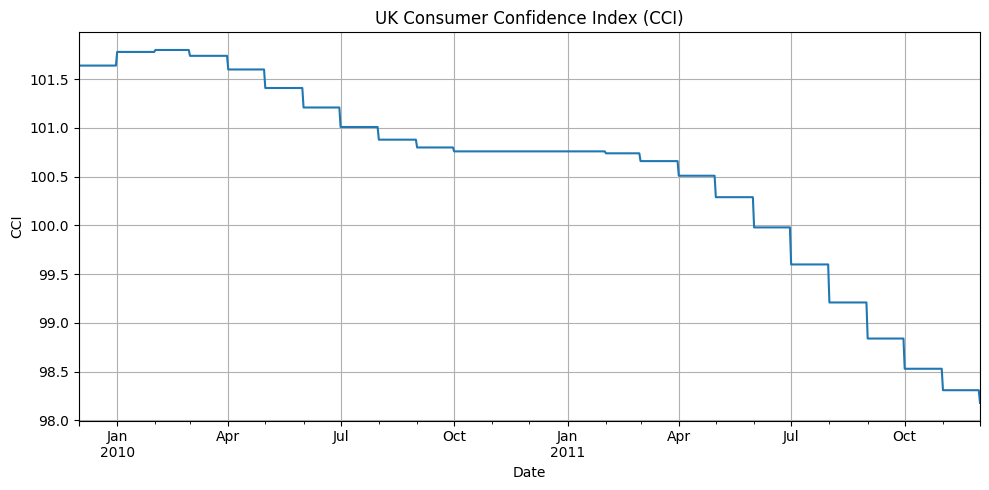

In [66]:
fig, ax = plt.subplots(figsize=(10,5))

uk_daily_cci.plot(ax=ax)

ax.set_title('UK Consumer Confidence Index (CCI)')
ax.set_xlabel('Date')
ax.set_ylabel('CCI')
ax.grid(True)
ax.legend().remove()

plt.tight_layout()
plt.show()

In [67]:
SAVE_DIR = '../../dataset/explanatory_variables'
SAVE_FILENAME = 'cci.json'

os.makedirs(SAVE_DIR, exist_ok=True)

# Convert to dictionary
cci = uk_daily_cci.to_dict()['CCI']

cci = {
    str(date): cci
    for date, cci in cci.items()
}

# Save as pretty-printed JSON
with open(os.path.join(SAVE_DIR, SAVE_FILENAME), 'w') as f:
    json.dump(cci, f, indent=4)

### Unemployment

In [68]:
# Source: https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms
URL = 'https://www.ons.gov.uk/generator?format=csv&uri=/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms'

response = requests.get(URL)

if response.status_code == 200:
    # Convert the content of the response to a StringIO object (to simulate file reading)
    csv_data = io.StringIO(response.text)
    
    # Read the CSV data into a DataFrame
    unemployment_df = pd.read_csv(csv_data)
    
    # Display the first few rows of the DataFrame
    print(unemployment_df.head())
else:
    print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")

               Title  \
0               CDID   
1  Source dataset ID   
2            PreUnit   
3               Unit   
4       Release date   

  Unemployment rate (aged 16 and over, seasonally adjusted): %  
0                                               MGSX            
1                                                LMS            
2                                                NaN            
3                                                  %            
4                                         15-04-2025            


In [69]:
monthly_unemployment_df = unemployment_df[
    lambda x: (
        x['Title'].str.match(r'^\d{4} [A-Z]{3}$', na=False)
    )
]
monthly_unemployment_df['unemploymentY: Index level (2015=100)'] = pd.to_numeric(
    monthly_unemployment_df['Unemployment rate (aged 16 and over, seasonally adjusted): %'], errors='coerce').dropna()
dates = pd.to_datetime(monthly_unemployment_df['Title'])
unemployment = monthly_unemployment_df['Unemployment rate (aged 16 and over, seasonally adjusted): %'].astype(float)

uk_monthly_unemployment_df = pd.DataFrame({
    'Date': dates,
    'unemployment': unemployment,
})

uk_monthly_unemployment_df = uk_monthly_unemployment_df[
    lambda x: (START_DATE <= x['Date']) & (x['Date'] <= END_DATE)
]

uk_monthly_unemployment = uk_monthly_unemployment_df.set_index('Date')
uk_monthly_unemployment

,unemployment
Date,
2009-12-01,7.7
2010-01-01,7.9
2010-02-01,8.0
2010-03-01,8.0
2010-04-01,7.9
2010-05-01,7.9
2010-06-01,7.8
2010-07-01,7.8
2010-08-01,7.8


In [70]:
uk_daily_unemployment = uk_monthly_unemployment.resample('D').mean()
uk_daily_unemployment = uk_daily_unemployment.sort_index()
uk_daily_unemployment = uk_daily_unemployment.ffill()
uk_daily_unemployment

,unemployment
Date,
2009-12-01,7.7
2009-12-02,7.7
2009-12-03,7.7
2009-12-04,7.7
2009-12-05,7.7
...,...
2011-11-27,8.4
2011-11-28,8.4
2011-11-29,8.4


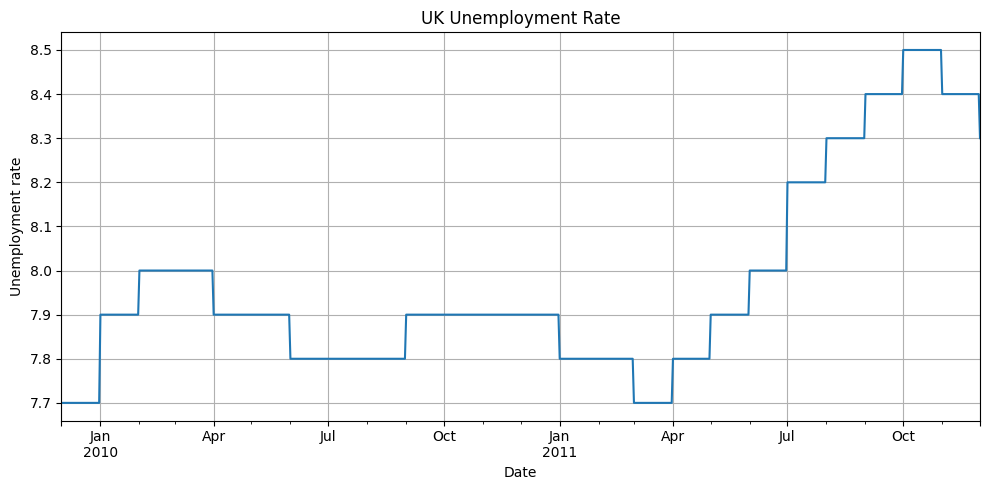

In [71]:
fig, ax = plt.subplots(figsize=(10,5))

uk_daily_unemployment.plot(ax=ax)

ax.set_title('UK Unemployment Rate')
ax.set_xlabel('Date')
ax.set_ylabel('Unemployment rate')
ax.grid(True)
ax.legend().remove()

plt.tight_layout()
plt.show()

In [72]:
SAVE_DIR = '../../dataset/explanatory_variables'
SAVE_FILENAME = 'unemployment.json'

os.makedirs(SAVE_DIR, exist_ok=True)

# Convert to dictionary
unemployment = uk_daily_unemployment.to_dict()['unemployment']

unemployment = {
    str(date): unemployment
    for date, unemployment in unemployment.items()
}

# Save as pretty-printed JSON
with open(os.path.join(SAVE_DIR, SAVE_FILENAME), 'w') as f:
    json.dump(unemployment, f, indent=4)

### Interest rates (SONIA)

In [78]:
# Source: https://www.bankofengland.co.uk/markets/sonia-benchmark/
URL = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'

payload = {
    'Datefrom'   : datetime.strptime(START_DATE, "%Y-%m-%d").strftime("%d/%b/%Y"),
    'Dateto'     : datetime.strptime(END_DATE, "%Y-%m-%d").strftime("%d/%b/%Y"),
    'SeriesCodes': 'IUDSOIA',
    'CSVF'       : 'TN',
    'UsingCodes' : 'Y',
    'VPD'        : 'Y',
    'VFD'        : 'N'
}

headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/54.0.2840.90 '
                  'Safari/537.36'
}


response = requests.get(URL, params=payload, headers=headers)

if response.status_code == 200:
    # Convert the content of the response to a StringIO object (to simulate file reading)
    csv_data = io.StringIO(response.text)
    
    # Read the CSV data into a DataFrame
    interest_rates_df = pd.read_csv(csv_data)
    
    # Display the first few rows of the DataFrame
    print(interest_rates_df.head())
else:
    print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")

          DATE  IUDSOIA
0  01 Dec 2009   0.4517
1  02 Dec 2009   0.4532
2  03 Dec 2009   0.4522
3  04 Dec 2009   0.4502
4  07 Dec 2009   0.4491


In [79]:
uk_daily_interest_rate_df = interest_rates_df.rename(columns={
    'DATE': 'Date',
    'IUDSOIA': 'InterestRatePct'
})
uk_daily_interest_rate_df['Date'] = pd.to_datetime(uk_daily_interest_rate_df['Date'], format='%d %b %Y')
uk_daily_interest_rate_df['InterestRatePct'] = pd.to_numeric(uk_daily_interest_rate_df['InterestRatePct']).astype(float)

uk_daily_interest_rate_df

,Date,InterestRatePct
0,2009-12-01,0.4517
1,2009-12-02,0.4532
2,2009-12-03,0.4522
3,2009-12-04,0.4502
4,2009-12-07,0.4491
...,...,...
520,2011-12-22,0.5138
521,2011-12-23,0.5037
522,2011-12-28,0.5086
523,2011-12-29,0.5012


In [80]:
uk_daily_interest_rate = uk_daily_interest_rate_df.set_index('Date').sort_index()
uk_daily_interest_rate = uk_daily_interest_rate.resample('D').mean().ffill()
uk_daily_interest_rate

,InterestRatePct
Date,
2009-12-01,0.4517
2009-12-02,0.4532
2009-12-03,0.4522
2009-12-04,0.4502
2009-12-05,0.4502
...,...
2011-12-26,0.5037
2011-12-27,0.5037
2011-12-28,0.5086


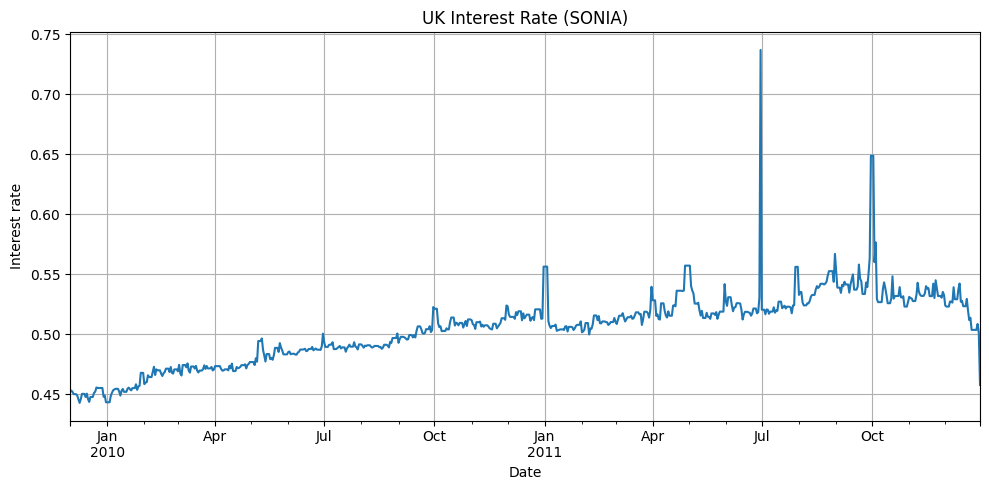

In [81]:
fig, ax = plt.subplots(figsize=(10,5))

uk_daily_interest_rate.plot(ax=ax)

ax.set_title('UK Interest Rate (SONIA)')
ax.set_xlabel('Date')
ax.set_ylabel('Interest rate')
ax.grid(True)
ax.legend().remove()

plt.tight_layout()
plt.show()

In [82]:
SAVE_DIR = '../../dataset/explanatory_variables'
SAVE_FILENAME = 'interest_rate.json'

os.makedirs(SAVE_DIR, exist_ok=True)

# Convert to dictionary
interest_rate = uk_daily_interest_rate.to_dict()['InterestRatePct']

interest_rate = {
    str(date): interest_rate
    for date, interest_rate in interest_rate.items()
}

# Save as pretty-printed JSON
with open(os.path.join(SAVE_DIR, SAVE_FILENAME), 'w') as f:
    json.dump(interest_rate, f, indent=4)